## Importing Libraries

In [0]:
# Import Hugging Face Library

!pip install transformers
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import random
import time
import matplotlib.pyplot as plt

## Checking for GPU

In [60]:
device_name = tf.test.gpu_device_name()

device_name

if torch.cuda.is_available():
  device=torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print('No GPU available')


There are 1 GPU(s) available.
We will use the GPU:  Tesla P100-PCIE-16GB


## Uploading Files

In [61]:
df = pd.read_csv('in_domain_train.tsv', delimiter = '\t', header=None, names=['source', 'label', 'notes', 'sentence'])
# df.drop(columns=['Unnamed: 0'], inplace=True)
df.sample(5)

,source,label,notes,sentence
2389,l-93,1,NaN,Angela characterized Shelly as a lifesaver.
5048,ks08,1,NaN,They're not finding it a stress being in the s...
3133,l-93,0,*,Paul exhaled on Mary.
5955,c_13,0,*,I ordered if John drink his beer.
625,bc01,1,NaN,Press the stamp against the pad completely.


## Tokenizing

In [0]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
text = df.sentence.values
labels=df.label.values
input_ids = []

for texts in text:
    try:
      encoded_text = tokenizer.encode(
      texts, 
      add_special_tokens = True
  )

      input_ids.append(encoded_text)
    
    except: 
        continue

## Checking the Maximum Length

In [63]:
print( 'Maximum token length is ',max([len(f) for f in input_ids]))


Maximum token length is  47


## Adding Padding to tokens

In [64]:
# Since maximum token length is 47, we can set the maximum allowable input to 64

max_len = 64

input_ids = pad_sequences( input_ids, maxlen = max_len, dtype = 'long', value = 0, truncating = 'post', padding = 'post')

print( 'Example of a padded sequence: ', input_ids[0])

Example of a padded sequence:  [  101  2256  2814  2180  1005  1056  4965  2023  4106  1010  2292  2894
  1996  2279  2028  2057 16599  1012   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [0]:
attention_masks = []

for f in input_ids:
  attn_mask = []
  for x in f: 
    if x > 0:
      attn_mask.append(1)
    else:
      attn_mask.append(0)
  attention_masks.append(attn_mask)

## Training and Cross-Validation

In [0]:
x_Train, x_Test, y_Train, y_Test = train_test_split( input_ids, labels, random_state= 1000, test_size=0.2 )
mask_Train, mask_Test, _, _ = train_test_split( attention_masks, labels, random_state= 1000, test_size=0.2 )

In [0]:
# Converting data to torch tensors

x_Train = torch.tensor(x_Train)
x_Test = torch.tensor(x_Test)

y_Train = torch.tensor(y_Train)
y_Test = torch.tensor(y_Test)

mask_Train = torch.tensor(mask_Train)
mask_Test = torch.tensor(mask_Test)

In [0]:
# Data will be trained in batches, hence to do this, we will use DataLoader library 
# Batch size needs to be specified, and for BERT advisable batch size is 16 or 32

batch_size = 32

train_data = TensorDataset( x_Train, mask_Train, y_Train )
train_sampler = RandomSampler( train_data )
train_dataloader = DataLoader( train_data, sampler = train_sampler, batch_size= batch_size)

test_data = TensorDataset( x_Test, mask_Test, y_Test )
test_sampler = RandomSampler( test_data )
test_dataloader = DataLoader( test_data, sampler = test_sampler, batch_size= batch_size)


## Training the model

In [69]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(), 
                  lr = 3e-5)

In [0]:
# Linear scheduler is used for learning rate decay

epochs = 10

steps = len( train_dataloader ) * epochs

scheduler = get_linear_schedule_with_warmup( optimizer, num_warmup_steps=0, num_training_steps= steps)

In [0]:
def flat_accuracy (preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [75]:
#Manually declare the seed value

seed_val = 42

random.seed( seed_val )
np.random.seed( seed_val )
torch.manual_seed ( seed_val )
torch.cuda.manual_seed( seed_val )

# Storing loss values to plot loss curves

loss_list = []

# For 4 epochs

for epoch in range(epochs):
  print('Epoch ', epoch)

  start = time.time()

  total_loss = 0

  model.train()

  for step, batch in enumerate(train_dataloader):

    # Data is read from dataloader object
    # Data is of three types, input ids, attention masks and labels in the respective orders
    # This data has to be stored on the gpu

    b_input_ids = batch[0].to(device)
    b_attn_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    #Reset gradient to zero

    model.zero_grad()

    # Run the model

    result = model( b_input_ids, attention_mask = b_attn_masks, labels = b_labels)

    #Output is obtained as a tuple

    loss = result[0]
    total_loss += loss.item()

    #Backward pass

    loss.backward()

    # Update optimizer

    optimizer.step()
    scheduler.step()

  avg_loss = total_loss / len(train_dataloader)
  loss_list.append(avg_loss)

  print('Average training loss: ', avg_loss)
  print('Time required: ',time.time()-start )


  #Running the validation set

  print('Running validation')

  start = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0,0
  batches = 0

  for step, batch in enumerate(test_dataloader):

    # Data is read from dataloader object
    # Data is of three types, input ids, attention masks and labels in the respective orders
    # This data has to be stored on the gpu

    b_input_ids = batch[0].to(device)
    b_attn_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    #Do not calculate gradient since this is validation step, saves computation time

    with torch.no_grad():

      # Run the model
      # As labels are not provided, model returns labels instead of loss function

      result = model( b_input_ids, attention_mask = b_attn_masks)

      #Output is obtained as a tuple
      # Logits are the final layer outputs without the activation function
      logits = result[0]

      # Extracting these logits from gpu to cpu

      logits = logits.detach().cpu().numpy()
      labels = b_labels.to('cpu').numpy()


      #Calculate cross-validation accuracy

      tmp_eval_accuracy = flat_accuracy( logits, labels)
      eval_accuracy += tmp_eval_accuracy
      batches += 1

  print( 'Cross valiadtion accuracy is: ', eval_accuracy/batches)
  print(' Validation time: ', time.time() - start)

print('Training done')

Epoch  0
Average training loss:  0.5076267319583447
Time required:  42.61753726005554
Running validation
Cross valiadtion accuracy is:  0.8103780864197531
 Validation time:  3.155696392059326
Epoch  1
Average training loss:  0.29862066133765974
Time required:  42.5837185382843
Running validation
Cross valiadtion accuracy is:  0.8290509259259259
 Validation time:  3.158214569091797
Epoch  2
Average training loss:  0.1629149700367005
Time required:  42.595804929733276
Running validation
Cross valiadtion accuracy is:  0.8359953703703703
 Validation time:  3.1619482040405273
Epoch  3
Average training loss:  0.0853187663907133
Time required:  42.58019828796387
Running validation
Cross valiadtion accuracy is:  0.838966049382716
 Validation time:  3.1628036499023438
Epoch  4
Average training loss:  0.059634513498031505
Time required:  42.59362578392029
Running validation
Cross valiadtion accuracy is:  0.8378858024691357
 Validation time:  3.1669671535491943
Epoch  5
Average training loss:  0.

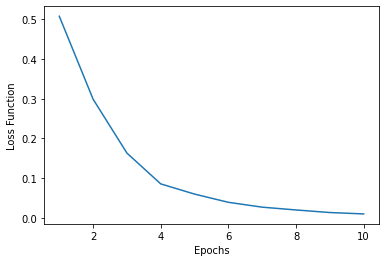

In [85]:
x= loss_list
y= [f for f in range(1,11)]
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
# plt.figure(figsize= (15,10))
plt.plot(y,x)
plt.show()